<a href="https://colab.research.google.com/github/AlaaAlq99/Graduation-Project/blob/main/LSTM_for_LTE_Network_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set() 
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D
%matplotlib inline
tf.compat.v1.disable_eager_execution()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dataset= pd.read_excel ("GM_Network_1095 Days.xlsx")

In [ ]:
# show the dataframe
dataset.columns

Index(['Date', 'Whole Network', 'Integrity',
       '(DIGIS2) DL Traffic Volume (GBytes)',
       '(DIGIS2) UL Traffic Volume (GBytes)', 'L.Traffic.ActiveUser.Avg',
       'L.Traffic.ActiveUser.DL.Avg'],
      dtype='object')

In [ ]:
dataset = dataset[['Date','(DIGIS2) DL Traffic Volume (GBytes)']].copy()
dataset.head()

,Date,(DIGIS2) DL Traffic Volume (GBytes)
0,2019-09-17,6745.8787
1,2019-09-18,7059.8912
2,2019-09-19,6973.2411
3,2019-09-20,7304.3743
4,2019-09-21,7438.8374


In [ ]:
#from date to time
#from text to date
dataset.Date = pd.to_datetime(dataset.Date, dayfirst = True)
#set attiribute as index
#data_copy.set_index("Date", inplace = True)
dataset.head()

,Date,(DIGIS2) DL Traffic Volume (GBytes)
0,2019-09-17,6745.8787
1,2019-09-18,7059.8912
2,2019-09-19,6973.2411
3,2019-09-20,7304.3743
4,2019-09-21,7438.8374


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Date                                 540 non-null    datetime64[ns]
 1   (DIGIS2) DL Traffic Volume (GBytes)  540 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [ ]:
dataset.describe()

,(DIGIS2) DL Traffic Volume (GBytes)
count,540.000000
mean,10581.987991
std,1678.960802
min,5789.016800
25%,9553.636750
50%,10385.239950
75%,11485.803700
max,16168.625600


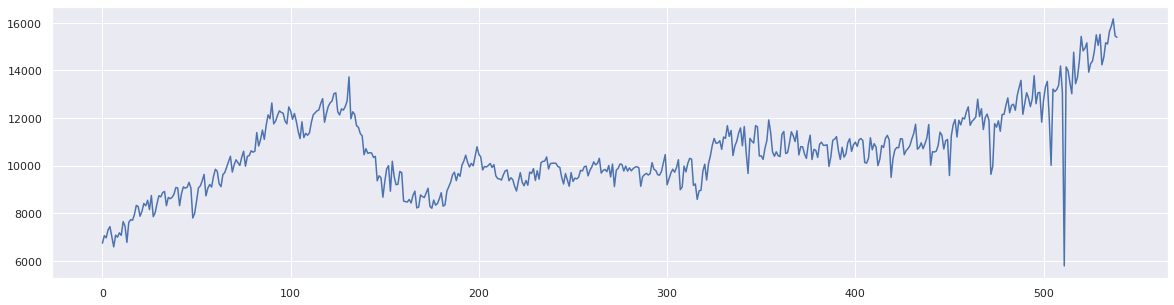

In [ ]:
dataset['(DIGIS2) DL Traffic Volume (GBytes)'].plot(figsize=(20,5))
plt.show()

In [ ]:
#detect outliers
Q1 = np.percentile(dataset['(DIGIS2) DL Traffic Volume (GBytes)'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(dataset['(DIGIS2) DL Traffic Volume (GBytes)'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", dataset.shape)
 
# Upper bound
upper = np.where(dataset['(DIGIS2) DL Traffic Volume (GBytes)'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(dataset['(DIGIS2) DL Traffic Volume (GBytes)'] <= (Q1-1.5*IQR))
 
#''' Removing the Outliers '''
#dataset.drop(upper[0], inplace = True)
#dataset.drop(lower[0], inplace = True)
print(len(lower[0]))
print(len(upper[0]))
print(lower[0])
print(upper[0])

Old Shape:  (540, 2)
2
17
[  6 511]
[516 520 521 522 523 527 528 529 530 532 533 534 535 536 537 538 539]


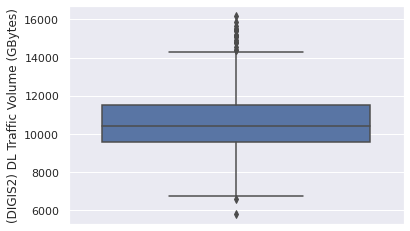

In [ ]:
sns.boxplot( y=dataset['(DIGIS2) DL Traffic Volume (GBytes)'])

In [ ]:
dataset['(DIGIS2) DL Traffic Volume (GBytes)'][lower[0]]

6      6590.5301
511    5789.0168
Name: (DIGIS2) DL Traffic Volume (GBytes), dtype: float64

In [ ]:
dataset['(DIGIS2) DL Traffic Volume (GBytes)'][lower[0]-1]

5       7020.8009
510    13089.6241
Name: (DIGIS2) DL Traffic Volume (GBytes), dtype: float64

In [ ]:
dataset['(DIGIS2) DL Traffic Volume (GBytes)'][upper[0]-7]

509    14189.4467
513    13993.6428
514    13488.9786
515    13022.0763
516    14766.9798
520    15430.1065
521    14823.1984
522    14936.7921
523    15159.9624
525    14285.3085
526    14398.1421
527    14818.8190
528    15495.6400
529    15054.6194
530    15516.7618
531    14236.9171
532    14554.4855
Name: (DIGIS2) DL Traffic Volume (GBytes), dtype: float64

In [ ]:
dataset['(DIGIS2) DL Traffic Volume (GBytes)'][upper[0]]

516    14766.9798
520    15430.1065
521    14823.1984
522    14936.7921
523    15159.9624
527    14818.8190
528    15495.6400
529    15054.6194
530    15516.7618
532    14554.4855
533    15165.8156
534    15111.6566
535    15639.4689
536    15858.6036
537    16168.6256
538    15456.7979
539    15392.0983
Name: (DIGIS2) DL Traffic Volume (GBytes), dtype: float64

In [ ]:
dataset['(DIGIS2) DL Traffic Volume (GBytes)'][lower[0]]= dataset['(DIGIS2) DL Traffic Volume (GBytes)'][lower[0]-1]
dataset['(DIGIS2) DL Traffic Volume (GBytes)'][lower[0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


6       7020.8009
511    13089.6241
Name: (DIGIS2) DL Traffic Volume (GBytes), dtype: float64

In [ ]:
dataset['(DIGIS2) DL Traffic Volume (GBytes)'][upper[0]]= dataset['(DIGIS2) DL Traffic Volume (GBytes)'][upper[0]-1]
dataset['(DIGIS2) DL Traffic Volume (GBytes)'][upper[0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


516    13022.0763
520    14385.1487
521    15430.1065
522    14823.1984
523    14936.7921
527    14398.1421
528    14818.8190
529    15495.6400
530    15054.6194
532    14236.9171
533    14554.4855
534    15165.8156
535    15111.6566
536    15639.4689
537    15858.6036
538    16168.6256
539    15456.7979
Name: (DIGIS2) DL Traffic Volume (GBytes), dtype: float64

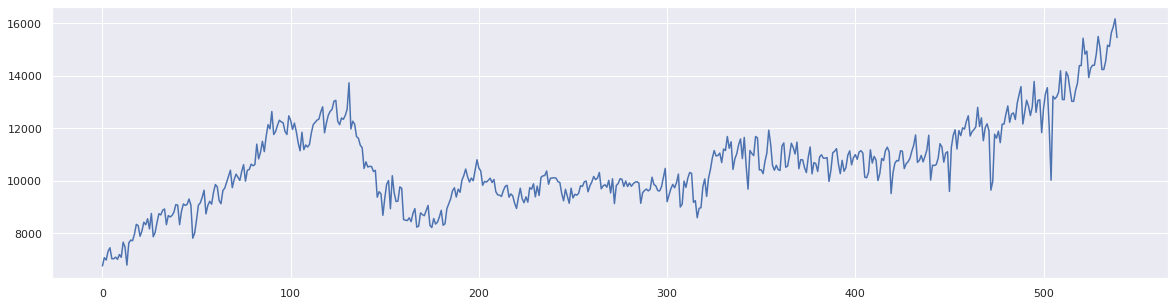

In [ ]:
dataset['(DIGIS2) DL Traffic Volume (GBytes)'].plot(figsize=(20,5))
plt.show()

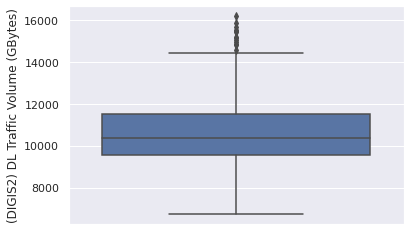

In [ ]:
#import sklearn
#from sklearn.datasets import load_boston
#plt.boxplot(dataset['(DIGIS2) DL Traffic Volume (GBytes)'])
#plt.show()
sns.boxplot( y=dataset['(DIGIS2) DL Traffic Volume (GBytes)'])

In [ ]:
#feature scaling >> normalize the data
scaler = MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(np.array(dataset['(DIGIS2) DL Traffic Volume (GBytes)']).reshape(-1, 1))
dataset['(DIGIS2) DL Traffic Volume (GBytes)'] = scaler.transform(np.array(
    dataset['(DIGIS2) DL Traffic Volume (GBytes)']).reshape(-1, 1)).flatten()

In [ ]:
dataset.describe()

,(DIGIS2) DL Traffic Volume (GBytes)
count,540.000000
mean,-0.184622
std,0.349547
min,-1.000000
25%,-0.400674
50%,-0.226931
75%,0.009880
max,1.000000


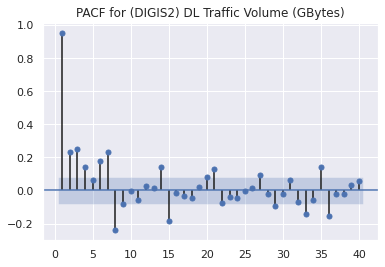

In [ ]:
#PACF
sgt.plot_pacf(dataset["(DIGIS2) DL Traffic Volume (GBytes)"],  lags = 40, zero = False, method = 'ols')
plt.title("PACF for (DIGIS2) DL Traffic Volume (GBytes)")
plt.show()

In [ ]:
dataset

,Date,(DIGIS2) DL Traffic Volume (GBytes)
0,2019-09-17,-1.000000
1,2019-09-18,-0.933350
2,2019-09-19,-0.951742
3,2019-09-20,-0.881458
4,2019-09-21,-0.852918
...,...,...
535,2021-03-05,0.775656
536,2021-03-06,0.887685
537,2021-03-07,0.934197
538,2021-03-08,1.000000


In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train = dataset.iloc[0:train_size ,:]
test  = dataset.iloc[train_size:len(dataset) ,:]
print(len(train), len(test))

361 179


In [ ]:
train

,Date,(DIGIS2) DL Traffic Volume (GBytes)
0,2019-09-17,-1.000000
1,2019-09-18,-0.933350
2,2019-09-19,-0.951742
3,2019-09-20,-0.881458
4,2019-09-21,-0.852918
...,...,...
356,2020-09-07,-0.186190
357,2020-09-08,-0.225044
358,2020-09-09,-0.185272
359,2020-09-10,-0.220506


In [ ]:
test

,Date,(DIGIS2) DL Traffic Volume (GBytes)
361,2020-09-12,-0.030343
362,2020-09-13,-0.004136
363,2020-09-14,-0.201120
364,2020-09-15,-0.192373
365,2020-09-16,-0.108535
...,...,...
535,2021-03-05,0.775656
536,2021-03-06,0.887685
537,2021-03-07,0.934197
538,2021-03-08,1.000000


In [ ]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14   # Number of past days we want to use to predict the future
for p in range(n_past):
  train['past_(DIGIS2) DL Traffic Volume (GBytes)'+'-'+str(p)] = train['(DIGIS2) DL Traffic Volume (GBytes)'].shift(-p)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
train

,Date,(DIGIS2) DL Traffic Volume (GBytes),past_(DIGIS2) DL Traffic Volume (GBytes)-0,past_(DIGIS2) DL Traffic Volume (GBytes)-1,past_(DIGIS2) DL Traffic Volume (GBytes)-2,past_(DIGIS2) DL Traffic Volume (GBytes)-3,past_(DIGIS2) DL Traffic Volume (GBytes)-4,past_(DIGIS2) DL Traffic Volume (GBytes)-5,past_(DIGIS2) DL Traffic Volume (GBytes)-6,past_(DIGIS2) DL Traffic Volume (GBytes)-7,past_(DIGIS2) DL Traffic Volume (GBytes)-8,past_(DIGIS2) DL Traffic Volume (GBytes)-9,past_(DIGIS2) DL Traffic Volume (GBytes)-10,past_(DIGIS2) DL Traffic Volume (GBytes)-11,past_(DIGIS2) DL Traffic Volume (GBytes)-12,past_(DIGIS2) DL Traffic Volume (GBytes)-13
0,2019-09-17,-1.000000,-1.000000,-0.933350,-0.951742,-0.881458,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029
1,2019-09-18,-0.933350,-0.933350,-0.951742,-0.881458,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029,-0.814759
2,2019-09-19,-0.951742,-0.951742,-0.881458,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029,-0.814759,-0.790647
3,2019-09-20,-0.881458,-0.881458,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029,-0.814759,-0.790647,-0.795943
4,2019-09-21,-0.852918,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029,-0.814759,-0.790647,-0.795943,-0.743851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2020-09-07,-0.186190,-0.186190,-0.225044,-0.185272,-0.220506,-0.227416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,2020-09-08,-0.225044,-0.225044,-0.185272,-0.220506,-0.227416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,2020-09-09,-0.185272,-0.185272,-0.220506,-0.227416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,2020-09-10,-0.220506,-0.220506,-0.227416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for t in range(n_past,n_past+n_future):
  
  train['future_(DIGIS2) DL Traffic Volume (GBytes)'+'-'+str(t)] = train['(DIGIS2) DL Traffic Volume (GBytes)'].shift(-t)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train

,Date,(DIGIS2) DL Traffic Volume (GBytes),past_(DIGIS2) DL Traffic Volume (GBytes)-0,past_(DIGIS2) DL Traffic Volume (GBytes)-1,past_(DIGIS2) DL Traffic Volume (GBytes)-2,past_(DIGIS2) DL Traffic Volume (GBytes)-3,past_(DIGIS2) DL Traffic Volume (GBytes)-4,past_(DIGIS2) DL Traffic Volume (GBytes)-5,past_(DIGIS2) DL Traffic Volume (GBytes)-6,past_(DIGIS2) DL Traffic Volume (GBytes)-7,past_(DIGIS2) DL Traffic Volume (GBytes)-8,past_(DIGIS2) DL Traffic Volume (GBytes)-9,past_(DIGIS2) DL Traffic Volume (GBytes)-10,past_(DIGIS2) DL Traffic Volume (GBytes)-11,past_(DIGIS2) DL Traffic Volume (GBytes)-12,past_(DIGIS2) DL Traffic Volume (GBytes)-13,future_(DIGIS2) DL Traffic Volume (GBytes)-14
0,2019-09-17,-1.000000,-1.000000,-0.933350,-0.951742,-0.881458,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029,-0.814759
1,2019-09-18,-0.933350,-0.933350,-0.951742,-0.881458,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029,-0.814759,-0.790647
2,2019-09-19,-0.951742,-0.951742,-0.881458,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029,-0.814759,-0.790647,-0.795943
3,2019-09-20,-0.881458,-0.881458,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029,-0.814759,-0.790647,-0.795943,-0.743851
4,2019-09-21,-0.852918,-0.852918,-0.941647,-0.941647,-0.928744,-0.946491,-0.907755,-0.930154,-0.807582,-0.847540,-0.993029,-0.814759,-0.790647,-0.795943,-0.743851,-0.663166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2020-09-07,-0.186190,-0.186190,-0.225044,-0.185272,-0.220506,-0.227416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357,2020-09-08,-0.225044,-0.225044,-0.185272,-0.220506,-0.227416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,2020-09-09,-0.185272,-0.185272,-0.220506,-0.227416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,2020-09-10,-0.220506,-0.220506,-0.227416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
trainX =  np.array(train.dropna()[[c for c in train.columns if 'past' in c]])
trainY =  np.array(train.dropna()[[c for c in train.columns if 'future' in c]])

In [ ]:
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14   # Number of past days we want to use to predict the future
for p in range(n_past):
  test['past_(DIGIS2) DL Traffic Volume (GBytes)'+'-'+str(p)] = test['(DIGIS2) DL Traffic Volume (GBytes)'].shift(-p)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
for t in range(n_past,n_past+n_future):
  
  test['future_(DIGIS2) DL Traffic Volume (GBytes)'+'-'+str(t)] = test['(DIGIS2) DL Traffic Volume (GBytes)'].shift(-t)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test

,Date,(DIGIS2) DL Traffic Volume (GBytes),past_(DIGIS2) DL Traffic Volume (GBytes)-0,past_(DIGIS2) DL Traffic Volume (GBytes)-1,past_(DIGIS2) DL Traffic Volume (GBytes)-2,past_(DIGIS2) DL Traffic Volume (GBytes)-3,past_(DIGIS2) DL Traffic Volume (GBytes)-4,past_(DIGIS2) DL Traffic Volume (GBytes)-5,past_(DIGIS2) DL Traffic Volume (GBytes)-6,past_(DIGIS2) DL Traffic Volume (GBytes)-7,past_(DIGIS2) DL Traffic Volume (GBytes)-8,past_(DIGIS2) DL Traffic Volume (GBytes)-9,past_(DIGIS2) DL Traffic Volume (GBytes)-10,past_(DIGIS2) DL Traffic Volume (GBytes)-11,past_(DIGIS2) DL Traffic Volume (GBytes)-12,past_(DIGIS2) DL Traffic Volume (GBytes)-13,future_(DIGIS2) DL Traffic Volume (GBytes)-14
361,2020-09-12,-0.030343,-0.030343,-0.004136,-0.201120,-0.192373,-0.108535,-0.006697,-0.041833,-0.094090,0.002620,-0.213117,-0.139334,-0.141151,-0.204173,-0.244189,-0.118844
362,2020-09-13,-0.004136,-0.004136,-0.201120,-0.192373,-0.108535,-0.006697,-0.041833,-0.094090,0.002620,-0.213117,-0.139334,-0.141151,-0.204173,-0.244189,-0.118844,-0.037195
363,2020-09-14,-0.201120,-0.201120,-0.192373,-0.108535,-0.006697,-0.041833,-0.094090,0.002620,-0.213117,-0.139334,-0.141151,-0.204173,-0.244189,-0.118844,-0.037195,-0.254222
364,2020-09-15,-0.192373,-0.192373,-0.108535,-0.006697,-0.041833,-0.094090,0.002620,-0.213117,-0.139334,-0.141151,-0.204173,-0.244189,-0.118844,-0.037195,-0.254222,-0.163185
365,2020-09-16,-0.108535,-0.108535,-0.006697,-0.041833,-0.094090,0.002620,-0.213117,-0.139334,-0.141151,-0.204173,-0.244189,-0.118844,-0.037195,-0.254222,-0.163185,-0.172400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,2021-03-05,0.775656,0.775656,0.887685,0.934197,1.000000,0.848913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536,2021-03-06,0.887685,0.887685,0.934197,1.000000,0.848913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,2021-03-07,0.934197,0.934197,1.000000,0.848913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,2021-03-08,1.000000,1.000000,0.848913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
testX =  np.array(test.dropna()[[c for c in test.columns if 'past' in c]])
testY =  np.array(test.dropna()[[c for c in test.columns if 'future' in c]])

In [ ]:
#trainX = tf.convert_to_tensor(trainX)
#trainY = tf.convert_to_tensor(trainY)
trainX=np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX =np.reshape(testX,(testX.shape[0],testX.shape[1],1))
#trainY=np.reshape(trainY,(trainY.shape[0],trainY.shape[1]#))

In [ ]:
trainX.shape,trainY.shape,testX.shape,testY.shape

((347, 14, 1), (347, 1), (165, 14, 1), (165, 1))

In [ ]:
XTraining, XValidation, YTraining, YValidation = train_test_split(trainX, trainY, test_size=0.2, random_state=1) # before model building   

In [ ]:
from keras.layers import Dense, Activation, Flatten

# define the Autoencoder model

model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(trainX.shape[1],1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(LSTM(16, activation='tanh', return_sequences=True))
model.add(LSTM(16, activation='tanh', return_sequences=True))
model.add(LSTM(16, activation='tanh', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Flatten())
model.add(Dense(trainY.shape[1],activation = 'tanh'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mae')
model.summary()
#,metrics=['mean_squared_error']

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 14, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 14, 16)            3136      
                                                                 
 lstm_4 (LSTM)               (None, 14, 16)            2

In [ ]:
# fit the model
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=False)
history = model.fit(XTraining,YTraining, batch_size=32, epochs=1000, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback])

Train on 277 samples, validate on 70 samples
Epoch 1/1000
277/277 [==============================] - ETA: 0s - loss: 0.3411

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


277/277 [==============================] - 8s 29ms/sample - loss: 0.3411 - val_loss: 0.3220
Epoch 2/1000
277/277 [==============================] - 1s 3ms/sample - loss: 0.3283 - val_loss: 0.3108
Epoch 3/1000
277/277 [==============================] - 1s 3ms/sample - loss: 0.3135 - val_loss: 0.2974
Epoch 4/1000
277/277 [==============================] - 1s 3ms/sample - loss: 0.2951 - val_loss: 0.2801
Epoch 5/1000
277/277 [==============================] - 1s 3ms/sample - loss: 0.2720 - val_loss: 0.2565
Epoch 6/1000
277/277 [==============================] - 1s 3ms/sample - loss: 0.2408 - val_loss: 0.2239
Epoch 7/1000
277/277 [==============================] - 1s 4ms/sample - loss: 0.2003 - val_loss: 0.1862
Epoch 8/1000
277/277 [==============================] - 1s 3ms/sample - loss: 0.1605 - val_loss: 0.1675
Epoch 9/1000
277/277 [==============================] - 1s 4ms/sample - loss: 0.1502 - val_loss: 0.1716
Epoch 10/1000
277/277 [==============================] - 1s 4ms/sample - los

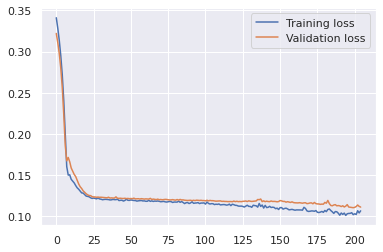

In [ ]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [ ]:
import math
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1,1))
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


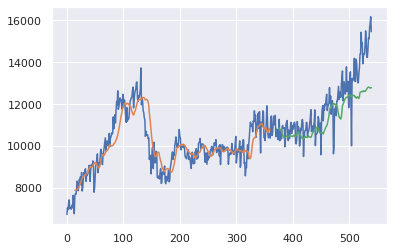

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset['(DIGIS2) DL Traffic Volume (GBytes)'])
trainPredictPlot[:] = np.nan
trainPredictPlot[n_past:len(trainPredict)+n_past] = trainPredict.transpose()
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset['(DIGIS2) DL Traffic Volume (GBytes)'])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(n_past*2):len(dataset)] = testPredict.transpose()
# plot baseline and predictions
plt.plot((scaler.inverse_transform(np.array(dataset['(DIGIS2) DL Traffic Volume (GBytes)']).reshape(1, -1)).flatten()))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()